# 2.8 手写数字识别之训练调试与优化

**第2.7节**我们研究了资源部署优化的方法，通过使用单GPU和分布式部署，提升模型训练的效率。本节我们依旧横向展开"横纵式"，如 **图1** 所示，探讨在手写数字识别任务中，为了保证模型的真实效果，在模型训练部分，对模型进行一些调试和优化的方法。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/1b710d7d137b4aed8c82adeb73684d31ca963afe837d433384762db1376872ed" width="1200" hegiht="" ></center>
<center>图1：“横纵式”教学法 — 训练过程</center>
<br></br>


训练过程优化思路主要有如下五个关键环节：

**（1）计算分类准确率，观测模型训练效果**

交叉熵损失函数只能作为优化目标，无法直接准确衡量模型的训练效果。准确率可以直接衡量训练效果，但由于其离散性质，不适合做为损失函数优化神经网络。
    
**（2）检查模型训练过程，识别潜在问题**

如果模型的损失或者评估指标表现异常，通常需要打印模型每一层的输入和输出来定位问题，分析每一层的内容来获取错误的原因。
    
**（3）加入校验或测试，更好评价模型效果**

理想的模型训练结果是在训练集和验证集上均有较高的准确率，如果训练集的准确率低于验证集，说明网络训练程度不够；如果训练集的准确率高于验证集，可能是发生了过拟合现象。通过在优化目标中加入正则化项的办法，解决过拟合的问题。
    
**（4）加入正则化项，避免模型过拟合**

飞桨框架支持为整体参数加入正则化项，这是通常的做法。此外，飞桨框架也支持为某一层或某一部分的网络单独加入正则化项，以达到精细调整参数训练的效果。

**（5）可视化分析**

用户不仅可以通过打印或使用matplotlib库作图，飞桨还提供了更专业的可视化分析工具VisualDL，提供便捷的可视化分析方法。

## 2.8.1 计算模型的分类准确率

准确率是一个直观衡量分类模型效果的指标，由于这个指标是离散的，因此不适合作为损失来优化。通常情况下，交叉熵损失越小的模型，分类的准确率也越高。基于分类准确率，我们可以公平地比较两种损失函数的优劣，例如在【手写数字识别】之损失函数章节中均方误差和交叉熵的比较。

使用飞桨提供的计算分类准确率API，可以直接计算准确率。

> *class* paddle.metric.Accuracy

该API的输入参数input为预测的分类结果predict，输入参数label为数据真实的label。飞桨还提供了更多衡量模型效果的计算指标，详细可以查看paddle.meric包下面的API。

在下述代码中，我们在模型前向计算过程forward函数中计算分类准确率，并在训练时打印每个批次样本的分类准确率。

In [ ]:
import paddle
from data_process import get_MNIST_dataloader

train_loader, test_loader = get_MNIST_dataloader()

In [ ]:
# 定义模型结构
import paddle.nn.functional as F
from paddle.nn import Conv2D, MaxPool2D, Linear

# 多层卷积神经网络实现
class MNIST(paddle.nn.Layer):
     def __init__(self):
         super(MNIST, self).__init__()
         
         # 定义卷积层，输出特征通道out_channels设置为20，卷积核的大小kernel_size为5，卷积步长stride=1，padding=2
         self.conv1 = Conv2D(in_channels=1, out_channels=20, kernel_size=5, stride=1, padding=2)
         # 定义池化层，池化核的大小kernel_size为2，池化步长为2
         self.max_pool1 = MaxPool2D(kernel_size=2, stride=2)
         # 定义卷积层，输出特征通道out_channels设置为20，卷积核的大小kernel_size为5，卷积步长stride=1，padding=2
         self.conv2 = Conv2D(in_channels=20, out_channels=20, kernel_size=5, stride=1, padding=2)
         # 定义池化层，池化核的大小kernel_size为2，池化步长为2
         self.max_pool2 = MaxPool2D(kernel_size=2, stride=2)
         # 定义一层全连接层，输出维度是10
         self.fc = Linear(in_features=980, out_features=10)
         
   # 定义网络前向计算过程，卷积后紧接着使用池化层，最后使用全连接层计算最终输出
   # 卷积层激活函数使用Relu，全连接层激活函数使用softmax
     def forward(self, inputs, label):
         x = self.conv1(inputs)
         x = F.relu(x)
         x = self.max_pool1(x)
         x = self.conv2(x)
         x = F.relu(x)
         x = self.max_pool2(x)
         x = paddle.reshape(x, [x.shape[0], 980])
         x = self.fc(x)
         if label is not None:
             acc = paddle.metric.accuracy(input=x, label=label)
             return x, acc
         else:
             return x

#在使用GPU机器时，可以将use_gpu变量设置成True
use_gpu = True
paddle.set_device('gpu:0') if use_gpu else paddle.set_device('cpu')

#仅优化算法的设置有所差别
def train(model):
    model = MNIST()
    model.train()
    
    #四种优化算法的设置方案，可以逐一尝试效果
    # opt = paddle.optimizer.SGD(learning_rate=0.01, parameters=model.parameters())
    # opt = paddle.optimizer.Momentum(learning_rate=0.01, momentum=0.9, parameters=model.parameters())
    # opt = paddle.optimizer.Adagrad(learning_rate=0.01, parameters=model.parameters())
    opt = paddle.optimizer.Adam(learning_rate=0.01, parameters=model.parameters())
    
    EPOCH_NUM = 5
    for epoch_id in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            #准备数据
            images, labels = data
            images = paddle.to_tensor(images)
            labels = paddle.to_tensor(labels)
            
            #前向计算的过程
            predicts, acc = model(images, labels)
            
            #计算损失，取一个批次样本损失的平均值
            loss = F.cross_entropy(predicts, labels)
            avg_loss = paddle.mean(loss)
            
            #每训练了100批次的数据，打印下当前Loss的情况
            if batch_id % 200 == 0:
                print("epoch: {}, batch: {}, loss is: {}, acc is {}".format(epoch_id, batch_id, avg_loss.numpy(), acc.numpy()))
                
            #后向传播，更新参数，消除梯度的过程
            avg_loss.backward()
            opt.step()
            opt.clear_grad()

    #保存模型参数
    paddle.save(model.state_dict(), 'mnist.pdparams')
    
#创建模型    
model = MNIST()
#启动训练过程
train(model)

W0905 14:35:13.571403    98 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 8.0, Driver API Version: 11.2, Runtime API Version: 11.2
W0905 14:35:13.574612    98 device_context.cc:465] device: 0, cuDNN Version: 8.2.


epoch: 0, batch: 0, loss is: [3.8877463], acc is [0.09375]
epoch: 0, batch: 200, loss is: [0.205946], acc is [0.921875]
epoch: 0, batch: 400, loss is: [0.01945284], acc is [1.]
epoch: 0, batch: 600, loss is: [0.0915114], acc is [0.96875]
epoch: 0, batch: 800, loss is: [0.07086004], acc is [0.984375]
epoch: 1, batch: 0, loss is: [0.06174702], acc is [0.984375]
epoch: 1, batch: 200, loss is: [0.02994888], acc is [0.984375]
epoch: 1, batch: 400, loss is: [0.06212441], acc is [0.96875]
epoch: 1, batch: 600, loss is: [0.11327725], acc is [0.96875]
epoch: 1, batch: 800, loss is: [0.03650226], acc is [0.984375]
epoch: 2, batch: 0, loss is: [0.03422514], acc is [0.984375]
epoch: 2, batch: 200, loss is: [0.00483766], acc is [1.]
epoch: 2, batch: 400, loss is: [0.023434], acc is [0.984375]
epoch: 2, batch: 600, loss is: [0.1054302], acc is [0.984375]
epoch: 2, batch: 800, loss is: [0.02677589], acc is [1.]
epoch: 3, batch: 0, loss is: [0.0193211], acc is [1.]
epoch: 3, batch: 200, loss is: [0.07

## 2.8.2 检查模型训练过程，识别潜在训练问题

使用飞桨动态图编程可以方便的查看和调试训练的执行过程。在网络定义的Forward函数中，可以打印每一层输入输出的尺寸，以及每层网络的参数。通过查看这些信息，不仅可以更好地理解训练的执行过程，还可以发现潜在问题，或者启发继续优化的思路。

在下述程序中，使用``check_shape``变量控制是否打印“尺寸”，验证网络结构是否正确。使用``check_content``变量控制是否打印“内容值”，验证数据分布是否合理。假如在训练中发现中间层的部分输出持续为0，说明该部分的网络结构设计存在问题，没有充分利用。

In [ ]:
import numpy as np
import paddle.nn.functional as F

# 定义模型结构
class MNIST(paddle.nn.Layer):
     def __init__(self):
         super(MNIST, self).__init__()
         
         # 定义卷积层，输出特征通道out_channels设置为20，卷积核的大小kernel_size为5，卷积步长stride=1，padding=2
         self.conv1 = Conv2D(in_channels=1, out_channels=20, kernel_size=5, stride=1, padding=2)
         # 定义池化层，池化核的大小kernel_size为2，池化步长为2
         self.max_pool1 = MaxPool2D(kernel_size=2, stride=2)
         # 定义卷积层，输出特征通道out_channels设置为20，卷积核的大小kernel_size为5，卷积步长stride=1，padding=2
         self.conv2 = Conv2D(in_channels=20, out_channels=20, kernel_size=5, stride=1, padding=2)
         # 定义池化层，池化核的大小kernel_size为2，池化步长为2
         self.max_pool2 = MaxPool2D(kernel_size=2, stride=2)
         # 定义一层全连接层，输出维度是10
         self.fc = Linear(in_features=980, out_features=10)
     
     #加入对每一层输入和输出的尺寸和数据内容的打印，根据check参数决策是否打印每层的参数和输出尺寸
     # 卷积层激活函数使用Relu，全连接层激活函数使用softmax
     def forward(self, inputs, label=None, check_shape=False, check_content=False):
         # 给不同层的输出不同命名，方便调试
         outputs1 = self.conv1(inputs)
         outputs2 = F.relu(outputs1)
         outputs3 = self.max_pool1(outputs2)
         outputs4 = self.conv2(outputs3)
         outputs5 = F.relu(outputs4)
         outputs6 = self.max_pool2(outputs5)
         outputs6 = paddle.reshape(outputs6, [outputs6.shape[0], -1])
         outputs7 = self.fc(outputs6)
         
         # 选择是否打印神经网络每层的参数尺寸和输出尺寸，验证网络结构是否设置正确
         if check_shape:
             # 打印每层网络设置的超参数-卷积核尺寸，卷积步长，卷积padding，池化核尺寸
             print("\n########## print network layer's superparams ##############")
             print("conv1-- kernel_size:{}, padding:{}, stride:{}".format(self.conv1.weight.shape, self.conv1._padding, self.conv1._stride))
             print("conv2-- kernel_size:{}, padding:{}, stride:{}".format(self.conv2.weight.shape, self.conv2._padding, self.conv2._stride))
             #print("max_pool1-- kernel_size:{}, padding:{}, stride:{}".format(self.max_pool1.pool_size, self.max_pool1.pool_stride, self.max_pool1._stride))
             #print("max_pool2-- kernel_size:{}, padding:{}, stride:{}".format(self.max_pool2.weight.shape, self.max_pool2._padding, self.max_pool2._stride))
             print("fc-- weight_size:{}, bias_size_{}".format(self.fc.weight.shape, self.fc.bias.shape))
             
             # 打印每层的输出尺寸
             print("\n########## print shape of features of every layer ###############")
             print("inputs_shape: {}".format(inputs.shape))
             print("outputs1_shape: {}".format(outputs1.shape))
             print("outputs2_shape: {}".format(outputs2.shape))
             print("outputs3_shape: {}".format(outputs3.shape))
             print("outputs4_shape: {}".format(outputs4.shape))
             print("outputs5_shape: {}".format(outputs5.shape))
             print("outputs6_shape: {}".format(outputs6.shape))
             print("outputs7_shape: {}".format(outputs7.shape))
             # print("outputs8_shape: {}".format(outputs8.shape))
             
         # 选择是否打印训练过程中的参数和输出内容，可用于训练过程中的调试
         if check_content:
            # 打印卷积层的参数-卷积核权重，权重参数较多，此处只打印部分参数
             print("\n########## print convolution layer's kernel ###############")
             print("conv1 params -- kernel weights:", self.conv1.weight[0][0])
             print("conv2 params -- kernel weights:", self.conv2.weight[0][0])

             # 创建随机数，随机打印某一个通道的输出值
             idx1 = np.random.randint(0, outputs1.shape[1])
             idx2 = np.random.randint(0, outputs4.shape[1])
             # 打印卷积-池化后的结果，仅打印batch中第一个图像对应的特征
             print("\nThe {}th channel of conv1 layer: ".format(idx1), outputs1[0][idx1])
             print("The {}th channel of conv2 layer: ".format(idx2), outputs4[0][idx2])
             print("The output of last layer:", outputs7[0], '\n')
            
        # 如果label不是None，则计算分类精度并返回
         if label is not None:
             acc = paddle.metric.accuracy(input=F.softmax(outputs7), label=label)
             return outputs7, acc
         else:
             return outputs7

#在使用GPU机器时，可以将use_gpu变量设置成True
use_gpu = True
paddle.set_device('gpu:0') if use_gpu else paddle.set_device('cpu')    

def train(model):
    model = MNIST()
    model.train()
    
    #四种优化算法的设置方案，可以逐一尝试效果
    opt = paddle.optimizer.SGD(learning_rate=0.01, parameters=model.parameters())
    # opt = paddle.optimizer.Momentum(learning_rate=0.01, momentum=0.9, parameters=model.parameters())
    # opt = paddle.optimizer.Adagrad(learning_rate=0.01, parameters=model.parameters())
    # opt = paddle.optimizer.Adam(learning_rate=0.01, parameters=model.parameters())
    
    EPOCH_NUM = 1
    for epoch_id in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            #准备数据，变得更加简洁
            images, labels = data
            images = paddle.to_tensor(images)
            labels = paddle.to_tensor(labels)
            
            #前向计算的过程，同时拿到模型输出值和分类准确率
            if batch_id == 0 and epoch_id==0:
                # 打印模型参数和每层输出的尺寸
                predicts, acc = model(images, labels, check_shape=True, check_content=False)
            elif batch_id==401:
                # 打印模型参数和每层输出的值
                predicts, acc = model(images, labels, check_shape=False, check_content=True)
            else:
                predicts, acc = model(images, labels)
            
            #计算损失，取一个批次样本损失的平均值
            loss = F.cross_entropy(predicts, labels)
            avg_loss = paddle.mean(loss)
            
            #每训练了100批次的数据，打印下当前Loss的情况
            if batch_id % 200 == 0:
                print("epoch: {}, batch: {}, loss is: {}, acc is {}".format(epoch_id, batch_id, avg_loss.numpy(), acc.numpy()))
            
            #后向传播，更新参数的过程
            avg_loss.backward()
            opt.step()
            opt.clear_grad()

    #保存模型参数
    paddle.save(model.state_dict(), 'mnist_test.pdparams')
    
#创建模型    
model = MNIST()
#启动训练过程
train(model)

print("Model has been saved.")


########## print network layer's superparams ##############
conv1-- kernel_size:[20, 1, 5, 5], padding:2, stride:[1, 1]
conv2-- kernel_size:[20, 20, 5, 5], padding:2, stride:[1, 1]
fc-- weight_size:[980, 10], bias_size_[10]

########## print shape of features of every layer ###############
inputs_shape: [64, 1, 28, 28]
outputs1_shape: [64, 20, 28, 28]
outputs2_shape: [64, 20, 28, 28]
outputs3_shape: [64, 20, 14, 14]
outputs4_shape: [64, 20, 14, 14]
outputs5_shape: [64, 20, 14, 14]
outputs6_shape: [64, 980]
outputs7_shape: [64, 10]
epoch: 0, batch: 0, loss is: [3.1953034], acc is [0.109375]
epoch: 0, batch: 200, loss is: [0.37904966], acc is [0.875]
epoch: 0, batch: 400, loss is: [0.16234186], acc is [0.984375]

########## print convolution layer's kernel ###############
conv1 params -- kernel weights: Tensor(shape=[5, 5], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [[-0.06305157, -0.24847564, -0.63125026,  0.16255459,  0.05321766],
        [ 0.27163783,  0.03359267,

## 2.8.3 加入校验或测试，更好评价模型效果 

在训练过程中，我们会发现模型在训练样本集上的损失在不断减小。但这是否代表模型在未来的应用场景上依然有效？为了验证模型的有效性，通常将样本集合分成三份，训练集、校验集和测试集。

- **训练集** ：用于训练模型的参数，即训练过程中主要完成的工作。
- **验证集** ：用于对模型超参数的选择，比如网络结构的调整、正则化项权重的选择等。
- **测试集** ：用于模拟模型在应用后的真实效果。因为测试集没有参与任何模型优化或参数训练的工作，所以它对模型来说是完全未知的样本。在不以校验数据优化网络结构或模型超参数时，校验数据和测试数据的效果是类似的，均更真实的反映模型效果。

如下程序读取上一步训练保存的模型参数，读取校验数据集，并测试模型在校验数据集上的效果。

In [ ]:
def evaluation(model):
    print('start evaluation .......')
    # 定义预测过程
    params_file_path = 'mnist.pdparams'
    # 加载模型参数
    param_dict = paddle.load(params_file_path)
    model.load_dict(param_dict)

    model.eval()
    eval_loader = test_loader

    acc_set = []
    avg_loss_set = []
    for batch_id, data in enumerate(eval_loader()):
        images, labels = data
        images = paddle.to_tensor(images)
        labels = paddle.to_tensor(labels)
        predicts, acc = model(images, labels)
        loss = F.cross_entropy(input=predicts, label=labels)
        avg_loss = paddle.mean(loss)
        acc_set.append(float(acc.numpy()))
        avg_loss_set.append(float(avg_loss.numpy()))
    
    #计算多个batch的平均损失和准确率
    acc_val_mean = np.array(acc_set).mean()
    avg_loss_val_mean = np.array(avg_loss_set).mean()

    print('loss={}, acc={}'.format(avg_loss_val_mean, acc_val_mean))

model = MNIST()
evaluation(model)

start evaluation .......
loss=0.06925583740963806, acc=0.9796974522292994


从测试的效果来看，模型在验证集上依然有98.6%的准确率，证明它是有预测效果的。

## 2.8.4 加入正则化项，避免模型过拟合
   
### 2.8.4.1 过拟合现象

对于样本量有限、但需要使用强大模型的复杂任务，模型很容易出现过拟合的表现，即在训练集上的损失小，在验证集或测试集上的损失较大，如 **图2** 所示。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/99b879c21113494a9d7315eeda74bc4c8fea07f984824a03bf8411e946c75f1b" width="400" hegiht="" ></center>
<center><br>图2：过拟合现象，训练误差不断降低，但测试误差先降后增</br></center>
<br></br>

反之，如果模型在训练集和测试集上均损失较大，则称为欠拟合。过拟合表示模型过于敏感，学习到了训练数据中的一些误差，而这些误差并不是真实的泛化规律（可推广到测试集上的规律）。欠拟合表示模型还不够强大，还没有很好的拟合已知的训练样本，更别提测试样本了。因为欠拟合情况容易观察和解决，只要训练loss不够好，就不断使用更强大的模型即可，因此实际中我们更需要处理好过拟合的问题。

### 2.8.4.2 导致过拟合原因

造成过拟合的原因是模型过于敏感，而训练数据量太少或其中的噪音太多。如**图3** 所示，理想的回归模型是一条坡度较缓的抛物线，欠拟合的模型只拟合出一条直线，显然没有捕捉到真实的规律，但过拟合的模型拟合出存在很多拐点的抛物线，显然是过于敏感，也没有正确表达真实规律。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/53c389bb3c824706bd2fbc05f83ab0c6dd6b5b2fdedb4150a17e16a1b64c243e" width="700" hegiht="" ></center>
<center><br>图3：回归模型的过拟合，理想和欠拟合状态的表现</br></center>
<br></br>

如**图4** 所示，理想的分类模型是一条半圆形的曲线，欠拟合用直线作为分类边界，显然没有捕捉到真实的边界，但过拟合的模型拟合出很扭曲的分类边界，虽然对所有的训练数据正确分类，但对一些较为个例的样本所做出的妥协，高概率不是真实的规律。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/b5a46f7e0fbe4f8686a71d9a2d330ed09f23bca565a44e0d941148729fd2f7d7" width="700" hegiht="" ></center>
<center><br>图4：分类模型的欠拟合，理想和过拟合状态的表现</br></center>
<br></br>


### 2.8.4.3 过拟合的成因与防控

为了更好的理解过拟合的成因，可以参考侦探定位罪犯的案例逻辑，如 **图5** 所示。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/34de60a675b64468a2c3fee0844a168d53e891eaacf643fd8c1c9ba8e3812bcc" width="700" hegiht="" ></center>
<center><br>图5：侦探定位罪犯与模型假设示意</br></center>
<br></br>

对于这个案例，假设侦探也会犯错，通过分析发现可能的原因：

（1）情况1：罪犯证据存在错误，依据错误的证据寻找罪犯肯定是缘木求鱼。

（2）情况2：搜索范围太大的同时证据太少，导致符合条件的候选（嫌疑人）太多，无法准确定位罪犯。

那么侦探解决这个问题的方法有两种：或者缩小搜索范围（比如假设该案件只能是熟人作案），或者寻找更多的证据。归结到深度学习中，假设模型也会犯错，通过分析发现可能的原因：

（1） 情况1：训练数据存在噪音，导致模型学到了噪音，而不是真实规律。

（2）情况2：使用强大模型（表示空间大）的同时训练数据太少，导致在训练数据上表现良好的候选假设太多，锁定了一个“虚假正确”的假设。


对于情况1，我们使用数据清洗和修正来解决。 对于情况2，我们或者限制模型表示能力，或者收集更多的训练数据。而清洗训练数据中的错误，或收集更多的训练数据往往是一句“正确的废话”，在任何时候我们都想获得更多更高质量的数据。在实际项目中，更快、更低成本可控制过拟合的方法，只有限制模型的表示能力。

**（1）正则化项**

为了防止模型过拟合，在没有扩充样本量的可能下，只能降低模型的复杂度，可以通过限制参数的数量或可能取值（参数值尽量小）实现。具体来说，在模型的优化目标（损失）中人为加入对参数规模的惩罚项。当参数越多或取值越大时，该惩罚项就越大。通过调整惩罚项的权重系数，可以使模型在“尽量减少训练损失”和“保持模型的泛化能力”之间取得平衡。泛化能力表示模型在没有见过的样本上依然有效。正则化项的存在，增加了模型在训练集上的损失。

飞桨支持为所有参数加上统一的正则化项，也支持为特定的参数添加正则化项。前者的实现如下代码所示，仅在优化器中设置``weight_decay``参数即可实现。使用参数``coeff``调节正则化项的权重，权重越大时，对模型复杂度的惩罚越高。

In [ ]:
def train(model):
    model.train() 

    #各种优化算法均可以加入正则化项，避免过拟合，参数regularization_coeff调节正则化项的权重
    opt = paddle.optimizer.Adam(learning_rate=0.01, weight_decay=paddle.regularizer.L2Decay(coeff=1e-5), parameters=model.parameters())           

    EPOCH_NUM = 5
    for epoch_id in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            #准备数据，变得更加简洁
            images, labels = data
            images = paddle.to_tensor(images)
            labels = paddle.to_tensor(labels)
            
            #前向计算的过程，同时拿到模型输出值和分类准确率
            predicts, acc = model(images, labels)
            #计算损失，取一个批次样本损失的平均值
            loss = F.cross_entropy(predicts, labels)
            avg_loss = paddle.mean(loss)
            
            #每训练了100批次的数据，打印下当前Loss的情况
            if batch_id % 200 == 0:
                print("epoch: {}, batch: {}, loss is: {}, acc is {}".format(epoch_id, batch_id, avg_loss.numpy(), acc.numpy()))
            
            #后向传播，更新参数的过程
            avg_loss.backward()
            opt.step()
            opt.clear_grad()

    #保存模型参数
    paddle.save(model.state_dict(), 'mnist_regul.pdparams')

model = MNIST()
train(model)

epoch: 0, batch: 0, loss is: [3.8228705], acc is [0.09375]
epoch: 0, batch: 200, loss is: [0.07062767], acc is [0.953125]
epoch: 0, batch: 400, loss is: [0.20030954], acc is [0.953125]
epoch: 0, batch: 600, loss is: [0.09374876], acc is [0.96875]
epoch: 0, batch: 800, loss is: [0.11705722], acc is [0.96875]
epoch: 1, batch: 0, loss is: [0.03310085], acc is [0.984375]
epoch: 1, batch: 200, loss is: [0.23823069], acc is [0.921875]
epoch: 1, batch: 400, loss is: [0.16660276], acc is [0.953125]
epoch: 1, batch: 600, loss is: [0.05889388], acc is [0.96875]
epoch: 1, batch: 800, loss is: [0.02532948], acc is [0.984375]
epoch: 2, batch: 0, loss is: [0.06577589], acc is [0.96875]
epoch: 2, batch: 200, loss is: [0.08367997], acc is [0.984375]
epoch: 2, batch: 400, loss is: [0.02483967], acc is [0.984375]
epoch: 2, batch: 600, loss is: [0.07011881], acc is [0.984375]
epoch: 2, batch: 800, loss is: [0.04859509], acc is [0.984375]
epoch: 3, batch: 0, loss is: [0.048246], acc is [0.984375]
epoch: 3

In [ ]:
def evaluation(model):
    print('start evaluation .......')
    # 定义预测过程
    params_file_path = 'mnist_regul.pdparams'
    # 加载模型参数
    param_dict = paddle.load(params_file_path)
    model.load_dict(param_dict)

    model.eval()
    eval_loader = test_loader

    acc_set = []
    avg_loss_set = []
    for batch_id, data in enumerate(eval_loader()):
        images, labels = data
        images = paddle.to_tensor(images)
        labels = paddle.to_tensor(labels)
        predicts, acc = model(images, labels)
        loss = F.cross_entropy(input=predicts, label=labels)
        avg_loss = paddle.mean(loss)
        acc_set.append(float(acc.numpy()))
        avg_loss_set.append(float(avg_loss.numpy()))
    
    #计算多个batch的平均损失和准确率
    acc_val_mean = np.array(acc_set).mean()
    avg_loss_val_mean = np.array(avg_loss_set).mean()

    print('loss={}, acc={}'.format(avg_loss_val_mean, acc_val_mean))

model = MNIST()
evaluation(model)

start evaluation .......
loss=0.07935721310694216, acc=0.9776074840764332


**（2）暂退法Dropout**

除了在优化目标中加入正则化项之外，神经网络模型也通常使用暂退法来改善过拟合问题。暂退法指在训练神经网络过程中随机丢掉一部分神经元来减少神经网络复杂度，它实现方法很简单：在每次迭代训练中，以一定概率随机屏蔽每一层中若干神经元，用余下神经元所构成网络来继续训练。

**图6**是暂退法示意图，左边是完整的神经网络，右边是应用了暂退法之后的网络结构。应用暂退法之后，会将标了×的神经元从网络中删除，让它们不向后面的层传递信号。在学习过程中，丢弃哪些神经元是随机决定，因此模型不会过度依赖某些神经元，能一定程度上抑制过拟合。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/541fd4620951432292578ed77fc1f74bc1ce5559060345d084e20319414a7f07" width="700" hegiht="" ></center>
<center><br>图6：暂退法示意图</br></center>
<br></br>

通过飞桨[paddle.nn.functional.dropout](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/nn/functional/dropout_cn.html#dropout) API可以实现Dropout操作。其输入是一个张量，即需要丢弃数据的神经元参数。该API的`axis`参数用于指定对输入张量进行Dropout操作的轴。默认为None，即对输入张量x中的任意元素，以丢弃概率p随机将一些元素输出置0。若参数`axis`不为None，则以一定的概率从图像特征或语音序列中丢弃掉整个通道。

需要注意的是，在测试时，应用整个训练好的模型，不需要Dropout。所以存在训练和测试不一致的问题。通过`paddle.nn.functional.dropout` API的`mode`参数可以选择丢弃单元的方式，有两种`upscale_in_train`和`downscale_in_infer`，默认是`upscale_in_train`。计算方法如下:

* upscale_in_train, 在训练时增大输出结果。
	* train: out = input * mask / ( 1.0 - p )
	* inference: out = input
* downscale_in_infer, 在预测时减小输出结果
	* train: out = input * mask
	* inference: out = input * (1.0 - p)
    
 示例：
 ```
 假定x是形状为2*3的2维张量:
[[1 2 3]
 [4 5 6]]
在对x做dropout时，程序会先生成一个和x相同形状的mask张量，mask中每个元素的值为0或1。
每个元素的具体值，则是依据丢弃概率从伯努利分布中随机采样得到。
比如，我们可能得到下面这样一个2*3的mask:
[[0 1 0]
 [1 0 1]]
将输入x和生成的mask点积，就得到了随机丢弃部分元素之后的结果:
[[0 2 0]
 [4 0 6]]
假定dropout的概率使用默认值，即 ``p=0.5`` ，若mode参数使用默认值，即 ``mode='upscale_in_train'`` ，
则在训练阶段，最终增大后的结果为:
[[0 4 0 ]
 [8 0 12]]
在测试阶段，输出跟输入一致:
[[1 2 3]
 [4 5 6]]
若参数mode设置为'downscale_in_infer'，则训练阶段的输出为:
[[0 2 0]
 [4 0 6]]
在测试阶段，缩小后的输出为:
[[0.5 1.  1.5]
 [2.  2.5 3. ]]
 ```

下面我们在MINIST模型全连接层后面加入Dropout运算，查看模型训练和评估情况。


In [ ]:
import paddle.nn.functional as F
# 定义模型结构
class MNIST(paddle.nn.Layer):
     def __init__(self):
         super(MNIST, self).__init__()
         
         # 定义卷积层，输出特征通道out_channels设置为20，卷积核的大小kernel_size为5，卷积步长stride=1，padding=2
         self.conv1 = Conv2D(in_channels=1, out_channels=20, kernel_size=5, stride=1, padding=2)
         # 定义池化层，池化核的大小kernel_size为2，池化步长为2
         self.max_pool1 = MaxPool2D(kernel_size=2, stride=2)
         # 定义卷积层，输出特征通道out_channels设置为20，卷积核的大小kernel_size为5，卷积步长stride=1，padding=2
         self.conv2 = Conv2D(in_channels=20, out_channels=20, kernel_size=5, stride=1, padding=2)
         # 定义池化层，池化核的大小kernel_size为2，池化步长为2
         self.max_pool2 = MaxPool2D(kernel_size=2, stride=2)
         # 定义一层全连接层，输出维度是10
         self.fc = Linear(in_features=980, out_features=10)
     
     #加入对每一层输入和输出的尺寸和数据内容的打印，根据check参数决策是否打印每层的参数和输出尺寸
     # 卷积层激活函数使用Relu，全连接层激活函数使用softmax
     def forward(self, inputs, label=None, check_shape=False, check_content=False, training=True):
         # 给不同层的输出不同命名，方便调试
         outputs1 = self.conv1(inputs)
         outputs2 = F.relu(outputs1)
         outputs3 = self.max_pool1(outputs2)
         outputs4 = self.conv2(outputs3)
         outputs5 = F.relu(outputs4)
         outputs6 = self.max_pool2(outputs5)
         outputs6 = paddle.reshape(outputs6, [outputs6.shape[0], -1])
         outputs7 = self.fc(outputs6)

         # 对FC层实施Dropout，指定第0维，丢弃概率为p
         outputs = paddle.nn.functional.dropout(outputs7,p=0.01, axis=0,training=training)

        # 如果label不是None，则计算分类精度并返回
         if label is not None:
             acc = paddle.metric.accuracy(input=F.softmax(outputs), label=label)
             return outputs, acc
         else:
             return outputs

def evaluation(model):
    print('start evaluation .......')
    # 定义预测过程
    params_file_path = 'mnist_regul.pdparams'
    # 加载模型参数
    param_dict = paddle.load(params_file_path)
    model.load_dict(param_dict)

    model.eval()
    eval_loader = test_loader

    acc_set = []
    avg_loss_set = []
    for batch_id, data in enumerate(eval_loader()):
        images, labels = data
        images = paddle.to_tensor(images)
        labels = paddle.to_tensor(labels)
        predicts, acc = model(images, labels, training=False)
        loss = F.cross_entropy(input=predicts, label=labels)
        avg_loss = paddle.mean(loss)
        acc_set.append(float(acc.numpy()))
        avg_loss_set.append(float(avg_loss.numpy()))
    
    #计算多个batch的平均损失和准确率
    acc_val_mean = np.array(acc_set).mean()
    avg_loss_val_mean = np.array(avg_loss_set).mean()

    print('loss={}, acc={}'.format(avg_loss_val_mean, acc_val_mean))

model = MNIST()
train(model)
evaluation(model)

epoch: 0, batch: 0, loss is: [4.0833225], acc is [0.0625]
epoch: 0, batch: 200, loss is: [0.07072611], acc is [1.]
epoch: 0, batch: 400, loss is: [0.13994697], acc is [0.96875]
epoch: 0, batch: 600, loss is: [0.10909003], acc is [0.953125]
epoch: 0, batch: 800, loss is: [0.1880557], acc is [0.96875]
epoch: 1, batch: 0, loss is: [0.22570458], acc is [0.9375]
epoch: 1, batch: 200, loss is: [0.2441752], acc is [0.921875]
epoch: 1, batch: 400, loss is: [0.0100032], acc is [1.]
epoch: 1, batch: 600, loss is: [0.04133706], acc is [0.984375]
epoch: 1, batch: 800, loss is: [0.09127815], acc is [0.953125]
epoch: 2, batch: 0, loss is: [0.05260755], acc is [0.96875]
epoch: 2, batch: 200, loss is: [0.13855451], acc is [0.953125]
epoch: 2, batch: 400, loss is: [0.05476269], acc is [0.984375]
epoch: 2, batch: 600, loss is: [0.30577427], acc is [0.921875]
epoch: 2, batch: 800, loss is: [0.31517652], acc is [0.9375]
epoch: 3, batch: 0, loss is: [0.06088963], acc is [0.984375]
epoch: 3, batch: 200, los

## 2.8.5 可视化分析

训练模型时，经常需要观察模型的评价指标，分析模型的优化过程，以确保训练是有效的。之前的分析，我们往往使用打印Loss的方式，这比较起来并不够方便，也不够美观。将模型训练效果等数据可视化作图可选用两种工具：Matplotlib库和VisualDL。

* Matplotlib库：Matplotlib库是Python中使用的最多的2D图形绘图库，它有一套完全仿照MATLAB的函数形式的绘图接口，使用轻量级的PLT库（Matplotlib）作图是非常简单的。

* VisualDL：如果期望使用更加专业的作图工具，可以尝试VisualDL，飞桨可视化分析工具。VisualDL能够有效地展示飞桨在运行过程中的计算图、各种指标变化趋势和数据信息。

### 2.8.5.1 使用Matplotlib库绘制损失随训练下降的曲线图

将训练的批次编号作为X轴坐标，该批次的训练损失作为Y轴坐标。

1. 训练开始前，声明两个列表变量存储对应的批次编号(iters=[])和训练损失(losses=[])。
```
iters=[]
losses=[]
for epoch_id in range(EPOCH_NUM):
	"""start to training"""
```

2. 随着训练的进行，将iter和losses两个列表填满。
```
import paddle.nn.functional as F

iters=[]
losses=[]
for epoch_id in range(EPOCH_NUM):
	for batch_id, data in enumerate(train_loader()):
        images, labels = data
        predicts, acc = model(images, labels)
        loss = F.cross_entropy(predicts, label = labels.astype('int64'))
        avg_loss = paddle.mean(loss)
        # 累计迭代次数和对应的loss
   	iters.append(batch_id + epoch_id*len(list(train_loader()))
	losses.append(avg_loss)
```

3. 训练结束后，将两份数据以参数形式导入PLT的横纵坐标。
```
plt.xlabel("iter", fontsize=14)，plt.ylabel("loss", fontsize=14)
```
4. 最后，调用plt.plot()函数即可完成作图。
```
plt.plot(iters, losses,color='red',label='train loss') 
```

详细代码如下：

In [ ]:
#引入matplotlib库
import matplotlib.pyplot as plt

def train(model):
    model.train()
    
    opt = paddle.optimizer.Adam(learning_rate=0.001, parameters=model.parameters())
    
    EPOCH_NUM = 10
    iter=0
    iters=[]
    losses=[]
    for epoch_id in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            #准备数据，变得更加简洁
            images, labels = data
            images = paddle.to_tensor(images)
            labels = paddle.to_tensor(labels)
            
            #前向计算的过程，同时拿到模型输出值和分类准确率
            predicts, acc = model(images, labels)
            #计算损失，取一个批次样本损失的平均值
            loss = F.cross_entropy(predicts, labels)
            avg_loss = paddle.mean(loss)
            
            #每训练了100批次的数据，打印下当前Loss的情况
            if batch_id % 100 == 0:
                print("epoch: {}, batch: {}, loss is: {}, acc is {}".format(epoch_id, batch_id, avg_loss.numpy(), acc.numpy()))
                iters.append(iter)
                losses.append(avg_loss.numpy())
                iter = iter + 100
            
            #后向传播，更新参数的过程
            avg_loss.backward()
            opt.step()
            opt.clear_grad()
            
    #保存模型参数
    paddle.save(model.state_dict(), 'mnist.pdparams')
    
    return iters, losses
    
model = MNIST()
iters, losses = train(model)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


epoch: 0, batch: 0, loss is: [3.1067178], acc is [0.125]
epoch: 0, batch: 100, loss is: [0.25948155], acc is [0.921875]
epoch: 0, batch: 200, loss is: [0.2500265], acc is [0.875]
epoch: 0, batch: 300, loss is: [0.32702205], acc is [0.890625]
epoch: 0, batch: 400, loss is: [0.08103482], acc is [0.96875]
epoch: 0, batch: 500, loss is: [0.06687161], acc is [0.96875]
epoch: 0, batch: 600, loss is: [0.18538702], acc is [0.96875]
epoch: 0, batch: 700, loss is: [0.03654159], acc is [0.984375]
epoch: 0, batch: 800, loss is: [0.08613557], acc is [0.953125]
epoch: 0, batch: 900, loss is: [0.22812071], acc is [0.953125]
epoch: 1, batch: 0, loss is: [0.07222291], acc is [0.984375]
epoch: 1, batch: 100, loss is: [0.02553116], acc is [1.]
epoch: 1, batch: 200, loss is: [0.0458651], acc is [0.984375]
epoch: 1, batch: 300, loss is: [0.04750751], acc is [0.96875]
epoch: 1, batch: 400, loss is: [0.13080978], acc is [0.9375]
epoch: 1, batch: 500, loss is: [0.05986679], acc is [0.96875]
epoch: 1, batch: 6

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


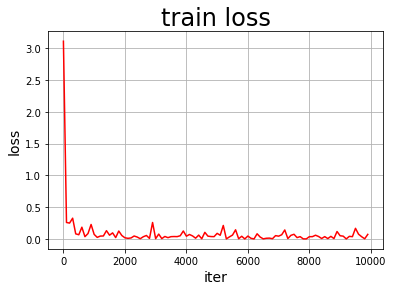

In [ ]:
#画出训练过程中Loss的变化曲线
plt.figure()
plt.title("train loss", fontsize=24)
plt.xlabel("iter", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.plot(iters, losses,color='red',label='train loss') 
plt.grid()
plt.show()

### 2.8.5.2 使用VisualDL可视化分析

VisualDL是飞桨可视化分析工具，以丰富的图表呈现训练参数变化趋势、数据样本、模型结构、PR曲线、ROC曲线、高维数据分布等。帮助用户清晰直观地理解深度学习模型训练过程及模型结构，进而实现高效的模型调优。与PLT库相比，VisualDL是更适合深度学习建模使用的可视化工具。

**推荐安装方式**：

In [ ]:
# 安装VisualDL
!python -m pip install visualdl -i https://mirror.baidu.com/pypi/simple

**使用方式**：

VisualDL将训练过程中的数据、参数等信息储存至日志文件中后，启动面板即可查看可视化结果。

**1. 记录日志**

VisualDL的后端提供了Python SDK，可通过LogWriter定制一个日志记录器，接口如下：

```
class LogWriter(logdir=None,
                max_queue=10,
                flush_secs=120,
                filename_suffix='',
                display_name='',
                file_name='',
                **kwargs)
```


In [ ]:
#引入VisualDL库，并设定保存作图数据的文件位置
from visualdl import LogWriter
log_writer = LogWriter(logdir="./log")

def train(model):
    model.train()
    
    opt = paddle.optimizer.Adam(learning_rate=0.001, parameters=model.parameters())
    
    EPOCH_NUM = 10
    iter = 0
    for epoch_id in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            #准备数据，变得更加简洁
            images, labels = data
            images = paddle.to_tensor(images)
            labels = paddle.to_tensor(labels)
            
            #前向计算的过程，同时拿到模型输出值和分类准确率
            predicts, avg_acc = model(images, labels)
            #计算损失，取一个批次样本损失的平均值
            loss = F.cross_entropy(predicts, labels)
            avg_loss = paddle.mean(loss)
            
            #每训练了100批次的数据，打印下当前Loss的情况
            if batch_id % 100 == 0:
                print("epoch: {}, batch: {}, loss is: {}, acc is {}".format(epoch_id, batch_id, avg_loss.numpy(), avg_acc.numpy()))
                log_writer.add_scalar(tag = 'acc', step = iter, value = avg_acc.numpy())
                log_writer.add_scalar(tag = 'loss', step = iter, value = avg_loss.numpy())
                iter = iter + 100

            #后向传播，更新参数的过程
            avg_loss.backward()
            opt.step()
            opt.clear_grad()

    #保存模型参数
    paddle.save(model.state_dict(), 'mnist.pdparams')
    
model = MNIST()
train(model)

epoch: 0, batch: 0, loss is: [3.8976812], acc is [0.125]
epoch: 0, batch: 100, loss is: [0.24494784], acc is [0.921875]
epoch: 0, batch: 200, loss is: [0.26378095], acc is [0.921875]
epoch: 0, batch: 300, loss is: [0.22967383], acc is [0.890625]
epoch: 0, batch: 400, loss is: [0.10998115], acc is [0.96875]
epoch: 0, batch: 500, loss is: [0.08789912], acc is [0.96875]
epoch: 0, batch: 600, loss is: [0.06132765], acc is [1.]
epoch: 0, batch: 700, loss is: [0.25114188], acc is [0.921875]
epoch: 0, batch: 800, loss is: [0.13402592], acc is [0.9375]
epoch: 0, batch: 900, loss is: [0.05303773], acc is [0.984375]
epoch: 1, batch: 0, loss is: [0.05307241], acc is [0.984375]
epoch: 1, batch: 100, loss is: [0.04524157], acc is [0.984375]
epoch: 1, batch: 200, loss is: [0.04033208], acc is [0.984375]
epoch: 1, batch: 300, loss is: [0.04626527], acc is [0.984375]
epoch: 1, batch: 400, loss is: [0.01260194], acc is [1.]
epoch: 1, batch: 500, loss is: [0.06764157], acc is [0.96875]
epoch: 1, batch: 

**2. 启动面板**

共有两种启动方式：

在命令行启动：使用命令行启动VisualDL面板，命令格式如下

`visualdl --logdir <dir_1, dir_2, ... , dir_n> --model <model_file> --host <host> --port <port> --cache-timeout <cache_timeout> --language <language> --public-path <public_path> --api-only`


In [12]:
!visualdl --logdir /home/aistudio/log --port 8080

在Python脚本中启动：支持在Python脚本中启动VisualDL面板，接口如下

```
visualdl.server.app.run(logdir,
                        model="path/to/model",
                        host="127.0.0.1",
                        port=8080,
                        cache_timeout=20,
                        language=None,
                        public_path=None,
                        api_only=False,
                        open_browser=False)
```

In [ ]:
import visualdl
import visualdl.server.app 
visualdl.server.app.run('/home/aistudio/log',
                        host="127.0.0.1",
                        port=8080,
                        cache_timeout=20)

**3. 使用LogReader获取日志中的数据**

VisualDL的后端也提供了获取日志数据的组件LogReader，可通过其获取日志中任意数据，接口如下：

`class LogReader(file_path='')`

## 作业题 2-4

* 将普通神经网络模型的每层输出打印，观察内容。
* 将分类准确率的指标 用PLT库画图表示。
* 通过分类准确率，判断以采用不同损失函数训练模型的效果优劣。
* 作图比较：随着训练进行，模型在训练集和测试集上的Loss曲线。
* 调节正则化权重，观察4的作图曲线的变化，并分析原因。